f=0, crack: origin to (1,0)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# Settings 
torch.set_default_dtype(torch.float64)   # use double for better derivative precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Domain: square [-1,1]^2 with crack along y=0 for x in [0,1)
X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0

# Training hyperparams
N_f = 4000       # collocation points
N_b_outer = 800  # boundary points on outer square
N_b_crack = 300  # boundary points on crack 
epochs = 20
#lr = 1
lambda_bc = 1.0   # weight for BC loss

def compute_phi(x, y):
    r = torch.sqrt(x**2 + y**2)
    return torch.sqrt(0.5 * (r - x))

#def compute_phi_derivs(x, y):
#    r = torch.sqrt(x**2 + y**2)
#    phi_x = (-0.5) * (0.5**0.5) * torch.sqrt(r - x) / r
#    phi_y = (0.5)  * (0.5**0.5) * torch.sqrt(r + x) / r

#    return phi_x.reshape(-1,1), phi_y.reshape(-1,1)
# 其實與下面一樣
def compute_phi_derivs(x, y):
    r = torch.sqrt(x**2 + y**2)
    phi_x = (0.25) * (2**0.5) * (x/r -1)/ torch.sqrt(r - x)
    phi_y = (0.25) * (2**0.5) * (y/r)/ torch.sqrt(r - x)

    return phi_x.reshape(-1,1), phi_y.reshape(-1,1)

In [9]:
# Neural network
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z) # no activation on last layer
        return z

In [10]:
# Derivative
def partials_U_wrt_inputs(model, x, y, phi):
    phi_det = phi.detach()  # ???ensure phi treated as independent input to U???
    inp = torch.cat([x, y, phi_det], dim=1).to(device) 
    inp.requires_grad_(True) #???

    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U), create_graph=True, retain_graph=True)[0]  # (N,3)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]
    return U, inp, U_x, U_y, U_z

def second_partials_U(model, inp, U_x, U_y, U_z):
    # grad_Ux=[U_xx, U_xy, U_xz]. size: N*3
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x), create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y), create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z), create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    #U_xy = grad_Ux[:,1:2]
    U_xz = grad_Ux[:,2:3]

    #U_yx = grad_Uy[:,0:1]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]

    #U_zx = grad_Uz[:,0:1]
    #U_zy = grad_Uz[:,1:2]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_laplace_uN(model, x, y):
    phi = compute_phi(x, y)
    U, inp, U_x, U_y, U_z = partials_U_wrt_inputs(model, x, y, phi)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)
    laplace_xU = U_xx + U_yy
    r = torch.sqrt(x**2 + y**2)
    #lap = laplace_xU + (0.5**0.5) / r * (torch.sqrt(r-x)* -U_xz + torch.sqrt(r+x)*U_yz) + (1/(4*r))*U_zz #其實與下面相同
    lap = laplace_xU + (0.5**0.5) / torch.sqrt(r-x) * ((x/r -1) * U_xz + (y/r) * U_yz) + (1/(4*(r-x)) *(1-(x/r)) )*U_zz

    return lap  # shape (N,1)

In [11]:
# Data sampling
def sample_collocation(N):
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN
    mask_crack = (torch.abs(y) < 1e-8) & (x >= 0.0)  # remove points on crack
    mask = ~mask_crack
    x = x[mask][:N]
    y = y[mask][:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []
    # left (x=-1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MIN)
    # right (x=1)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1))
    xs.append(torch.ones_like(ys[-1]) * X_MAX)
    # bottom (y=-1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    # top (y=1)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1))
    ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    return x.view(-1,1).to(device), y.view(-1,1).to(device)

def sample_crack_boundary(N):
    # 在 0 < x <= 1 取 N 個均勻點，避開 x=0
    x_vals = torch.linspace(0, 1, N + 1)[1:].unsqueeze(1).to(device)  # x=0 不取
    y_vals = torch.zeros_like(x_vals).to(device)  # y=0

    return x_vals, y_vals


# model
layers = [3, 64, 1]  
model = MLP(layers).to(device)

# Training data
x_f, y_f = sample_collocation(N_f)
x_b_out, y_b_out = sample_outer_boundary(N_b_outer)
x_b_crack, y_b_crack = sample_crack_boundary(N_b_crack)

# boundary values
with torch.no_grad():
    phi_b_out = compute_phi(x_b_out, y_b_out)
    g_b_out = phi_b_out.clone()
    phi_b_crack = compute_phi(x_b_crack, y_b_crack)
    g_b_crack = phi_b_crack.clone()
    

# concatenate all boundary points
x_b = torch.cat([x_b_out, x_b_crack], dim=0)
y_b = torch.cat([y_b_out, y_b_crack], dim=0)
g_b = torch.cat([g_b_out, g_b_crack], dim=0)

loss_history = []
relL2_history = []

def relative_L2_error(model, ntest=10000):
    # uniform grid 
    nx = int(np.sqrt(ntest))
    xs = np.linspace(X_MIN, X_MAX, nx)
    ys = np.linspace(Y_MIN, Y_MAX, nx)
    Xg, Yg = np.meshgrid(xs, ys)
    Xg = Xg.flatten()[:,None]
    Yg = Yg.flatten()[:,None]
    x_test = torch.from_numpy(Xg).to(device).double()
    y_test = torch.from_numpy(Yg).to(device).double()
    # mask crack
    mask = ~((torch.abs(y_test) < 1e-8) & (x_test >= 0.0))
    x_test = x_test[mask]
    y_test = y_test[mask]
    with torch.no_grad():
        phi_test = compute_phi(x_test, y_test)
        x_test = x_test.view(-1,1)
        y_test = y_test.view(-1,1)
        phi_test = phi_test.view(-1,1)
        # predict u_N
        inp = torch.cat([x_test, y_test, phi_test.detach()], dim=1)
        u_pred = model(inp)
        u_true = phi_test
        num = torch.norm((u_pred - u_true).cpu())
        den = torch.norm(u_true.cpu())
        return (num / den).item()

In [12]:
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training with LBFGS on device:", device)

for ep in range(epochs):

    def closure():
        optimizer.zero_grad()
        # PDE loss
        lap_u = compute_laplace_uN(model, x_f, y_f)  # shape (N_f,1)
        residual = -lap_u  # f=0
        loss_pde = torch.mean(residual**2)

        # boundary loss
        phi_b = compute_phi(x_b, y_b)
        inp_bc = torch.cat([x_b, y_b, phi_b.detach()], dim=1)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)

        loss = loss_pde + lambda_bc * loss_bc
        loss.backward()
        return loss

    loss = optimizer.step(closure)   # closure 被 optimizer 多次呼叫

    loss_history.append(loss.item())

    if ep % 1 == 0 or ep == epochs-1:
        relL2 = relative_L2_error(model, ntest=4096)
        relL2_history.append((ep, relL2))
        print(f"Epoch {ep:5d} | Loss {loss.item():.3e} | relL2 {relL2:.3e}")

print("Training finished.")
# final error
relL2 = relative_L2_error(model, ntest=10000)
print("Final relative L2 error:", relL2)


Start training with LBFGS on device: cpu
Epoch     0 | Loss 6.445e-01 | relL2 7.002e-03
Epoch     1 | Loss 1.403e-04 | relL2 9.581e-04
Epoch     2 | Loss 1.198e-05 | relL2 9.249e-04
Epoch     3 | Loss 4.863e-06 | relL2 1.236e-03
Epoch     4 | Loss 3.110e-06 | relL2 5.915e-04
Epoch     5 | Loss 1.386e-06 | relL2 4.160e-04
Epoch     6 | Loss 8.503e-07 | relL2 4.244e-04
Epoch     7 | Loss 8.441e-07 | relL2 4.244e-04
Epoch     8 | Loss 8.441e-07 | relL2 4.244e-04
Epoch     9 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    10 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    11 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    12 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    13 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    14 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    15 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    16 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    17 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    18 | Loss 8.441e-07 | relL2 4.244e-04
Epoch    19 | Loss 8.441e-07 | relL2 4.244e-04
Training finished.


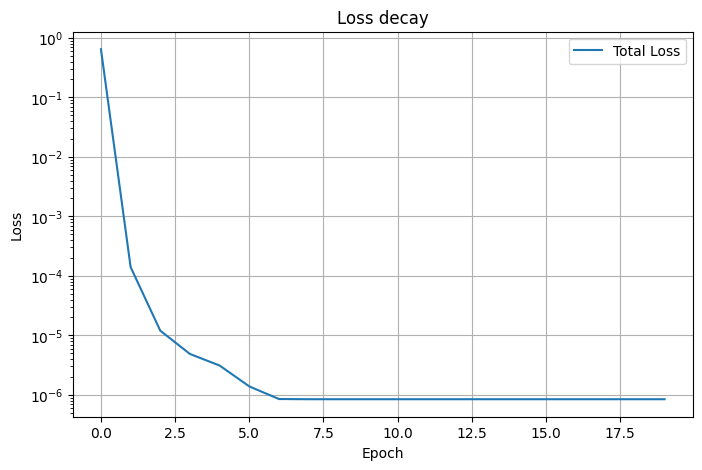

Relative L2 error (grid): 0.00042357597045525645


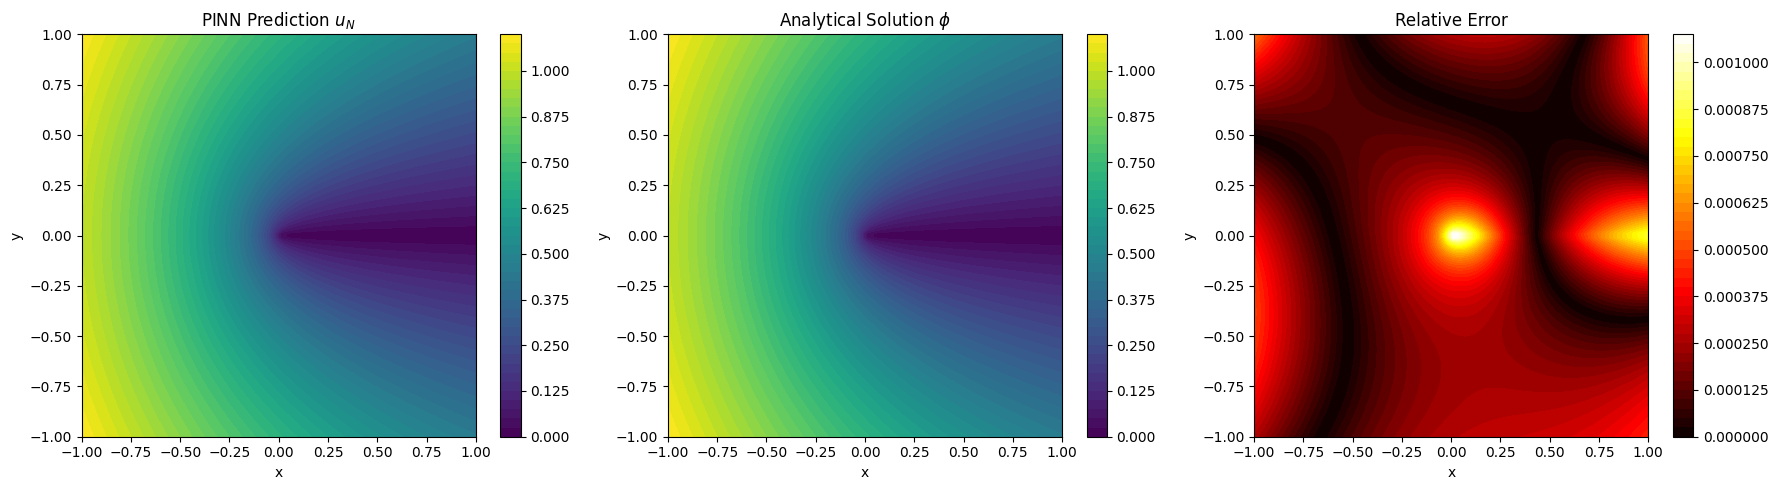

In [13]:
# 畫Loss
plt.figure(figsize=(8,5))
plt.semilogy(loss_history, label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss decay")
plt.grid(True)
plt.show()

# 測試網格
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)
x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()

# 真解
with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid)
    phi_grid_np = phi_grid.cpu().numpy().reshape(nx, nx)

# 預測解
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

# 逐點相對誤差
#error_rel = np.abs(u_pred - phi_grid_np) / (np.abs(phi_grid_np))
#u_inf_norm = np.max(np.abs(u_pred))   # 預測解的 inf norm
phi_inf_norm = np.max(np.abs(phi_grid_np))   # 真實解的 inf norm
#error_rel = np.abs(u_pred - phi_grid_np) / (u_inf_norm) 
error_rel = np.abs(u_pred - phi_grid_np) / (phi_inf_norm)  

# 整體相對誤差
error_tensor = torch.from_numpy(np.abs(u_pred - phi_grid_np)).double()
phi_tensor = torch.from_numpy(np.abs(phi_grid_np)).double()
relL2 = torch.norm(error_tensor) / torch.norm(phi_tensor)
print("Relative L2 error (grid):", relL2.item())

# 畫圖
fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('PINN Prediction $u_N$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

im1 = axs[1].contourf(Xg, Yg, phi_grid_np, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title('Analytical Solution $\\phi$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

im2 = axs[2].contourf(Xg, Yg, error_rel, 50, cmap='hot')
fig.colorbar(im2, ax=axs[2])
axs[2].set_title('Relative Error')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')

plt.tight_layout()
plt.show()